# Random Forest
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   level   1206 non-null   int64 
 1   int     1206 non-null   int64 
 2   book    1206 non-null   object
 3   str     1206 non-null   int64 
 4   ac      1206 non-null   int64 
 5   con     1206 non-null   int64 
 6   cha     1206 non-null   int64 
 7   hp      1206 non-null   int64 
 8   dex     1206 non-null   int64 
 9   wis     1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,level,int,book,str,ac,con,cha,hp,dex,wis
0,10,1,Pathfinder Bestiary,7,29,5,1,215,2,2
1,10,-4,Pathfinder Bestiary,9,28,5,1,220,0,2
2,8,-4,Pathfinder Bestiary,7,25,6,-2,175,3,3
3,17,6,Pathfinder Bestiary,7,41,5,6,315,4,5
4,1,-1,Pathfinder Bestiary,-5,16,1,1,20,3,1


###### Level

In [4]:
y = df["level"]

In [5]:
print(y)

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64


In [6]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [7]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
print(level_count)

    lvl  count
0    -1     34
1     0     27
2     1    127
3     2    121
4     3     95
5     4     82
6     5     76
7     6     72
8     7     77
9     8     68
10    9     63
11   10     58
12   11     40
13   12     41
14   13     36
15   14     33
16   15     31
17   16     25
18   17     21
19   18     21
20   19     18
21   20     24
22   21     16


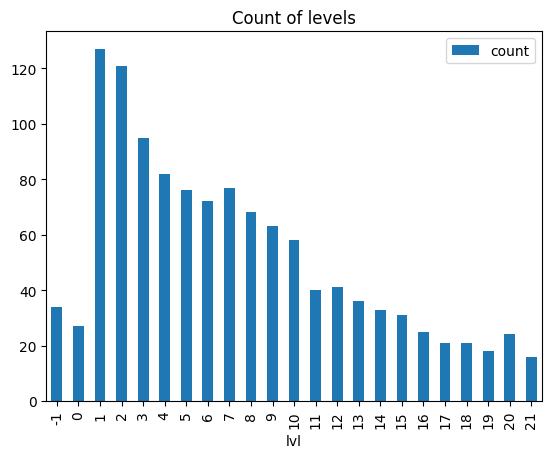

In [8]:
import matplotlib.pyplot as plt

level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [9]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [10]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [11]:
X_train = X_train.astype("int64")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 840
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   int     841 non-null    int64
 1   str     841 non-null    int64
 2   ac      841 non-null    int64
 3   con     841 non-null    int64
 4   cha     841 non-null    int64
 5   hp      841 non-null    int64
 6   dex     841 non-null    int64
 7   wis     841 non-null    int64
dtypes: int64(8)
memory usage: 59.1 KB


In [12]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [13]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [14]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## Chronological split

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [16]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [17]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.23
RMSE: 1.49


RMSE is large. Let's see value after tuning.

In [18]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.22
RMSE test: 1.49


No overfitting

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.23
RMSE: 1.49

Round type: round
MSE: 2.52
RMSE: 1.59

Round type: 0.33
MSE: 2.16
RMSE: 1.47

Round type: 0.45
MSE: 2.52
RMSE: 1.59



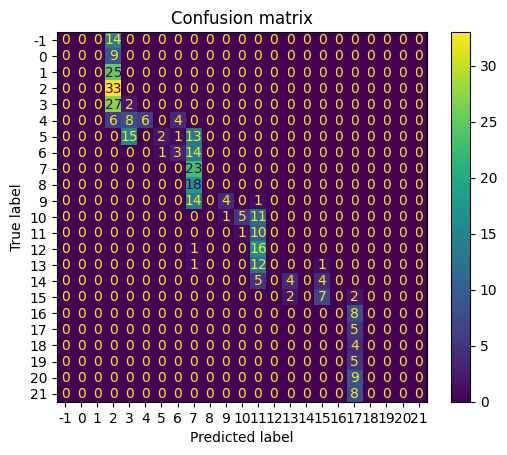

In [20]:
plot_confusion_matrix("round", y_pred_test, y_test)

### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [23]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   4.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.6s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.3s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.6s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 800, 'max_features': 0.5, 'max_depth': 100}

In [24]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.17
RMSE test: 0.67
MSE test: 0.45



(0.6728410584211254, 0.45271508989726034)

### Attempt to decrease overfitting
Change max_depth to 7

In [25]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=100, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.30
RMSE test: 0.69
MSE test: 0.48



(0.6919592980359309, 0.47880767013837827)

Overfitting decreased.

Check rounded predictions

In [26]:
from copy import deepcopy

predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.48
RMSE: 0.69

Round type: round
MSE: 0.50
RMSE: 0.71

Round type: 0.33
MSE: 0.46
RMSE: 0.68

Round type: 0.45
MSE: 0.51
RMSE: 0.71



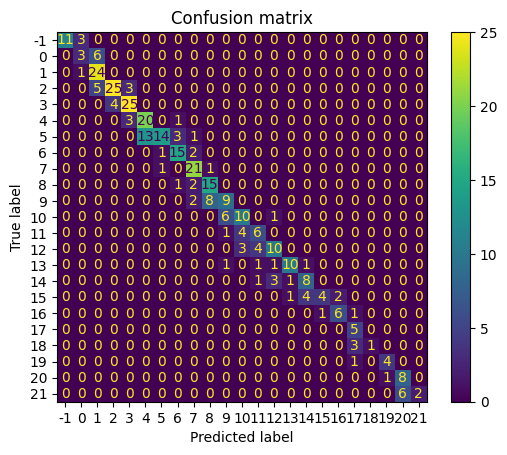

In [27]:
plot_confusion_matrix("round", predict, y_test)

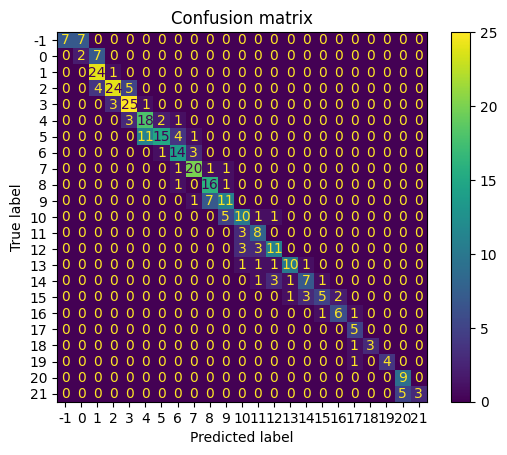

In [28]:
round_predict_33 = np.where(
    (predict % 1) > 0.33, np.ceil(predict), np.floor(predict)
).astype("int")

plot_confusion_matrix("round", round_predict_33, y_test)

The best results for threshold = 0.33

## Random split

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [30]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [31]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.67
RMSE: 1.29


In [32]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.67
RMSE: 1.29

Round type: round
MSE: 1.81
RMSE: 1.35

Round type: 0.33
MSE: 1.82
RMSE: 1.35

Round type: 0.45
MSE: 1.82
RMSE: 1.35



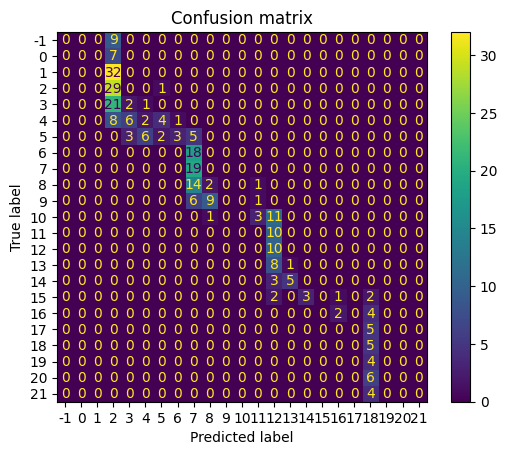

In [33]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [34]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [35]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.3s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.9s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.1s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.3s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.1s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.8s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 100, 'max_features': 0.5, 'max_depth': 20}

In [36]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.18
RMSE test: 0.49
MSE test: 0.24



(0.48854629611093014, 0.23867748344370862)

### Attempt to decrease overfitting
Change max_depth to 7

In [37]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=400, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.44
RMSE test: 0.46
MSE test: 0.21



(0.4590184047118999, 0.21069789586425752)

Check rounded predictions

In [38]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.21
RMSE: 0.46

Round type: round
MSE: 0.23
RMSE: 0.48

Round type: 0.33
MSE: 0.22
RMSE: 0.47

Round type: 0.45
MSE: 0.23
RMSE: 0.47



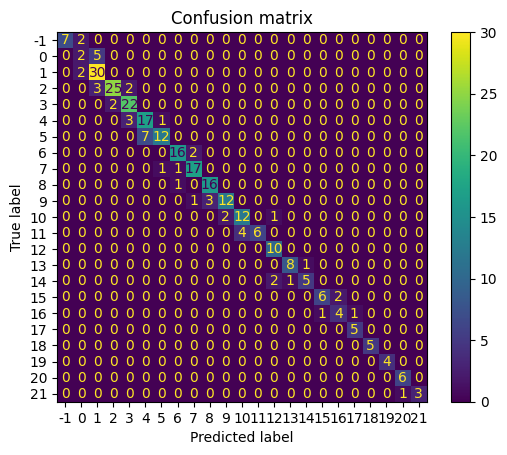

In [39]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

In [40]:
round_predict_33_random_split = np.where(
    (predict_random_split % 1) > 0.33,
    np.ceil(predict_random_split),
    np.floor(predict_random_split),
).astype("int")

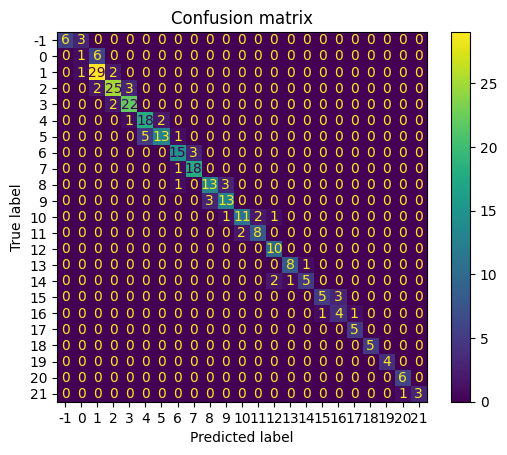

In [41]:
plot_confusion_matrix("round", round_predict_33_random_split, y_test_random_split)

### Podsumowanie:

* Wyniki zadowalające.
* Wyniki poprawiły się względem regesji liniowej.
* Dla podziału chronologicznego dostajemy słabe dopasowanie dla danych testowych. Być może dla większej ilości książek będzie lepiej.

### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [42]:
current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   level       1206 non-null   int64 
 1   int         1206 non-null   int64 
 2   book        1206 non-null   object
 3   str         1206 non-null   int64 
 4   will        1206 non-null   int64 
 5   ac          1206 non-null   int64 
 6   con         1206 non-null   int64 
 7   fortitude   1206 non-null   int64 
 8   reflex      1206 non-null   int64 
 9   focus       1206 non-null   int32 
 10  cha         1206 non-null   int64 
 11  hp          1206 non-null   int64 
 12  perception  1206 non-null   int64 
 13  dex         1206 non-null   int64 
 14  wis         1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [44]:
df.head()

,level,int,book,str,will,ac,con,fortitude,reflex,focus,cha,hp,perception,dex,wis
0,10,1,Pathfinder Bestiary,7,17,29,5,22,19,1,1,215,20,2,2
1,10,-4,Pathfinder Bestiary,9,16,28,5,21,14,0,1,220,16,0,2
2,8,-4,Pathfinder Bestiary,7,15,25,6,20,17,0,-2,175,17,3,3
3,17,6,Pathfinder Bestiary,7,32,41,5,30,29,1,6,315,30,4,5
4,1,-1,Pathfinder Bestiary,-5,4,16,1,6,10,1,1,20,6,3,1


## Train test split

### Chronological split

In [45]:
from training.splitting_dataset import split_dataframe

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [46]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [47]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [48]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [49]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

### With chronological split

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [51]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [52]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.12
RMSE: 1.45


In [53]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")  # overfitting

RMSE train: 1.20
RMSE test: 1.45


In [54]:
check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.12
RMSE: 1.45

Round type: round
MSE: 2.38
RMSE: 1.54

Round type: 0.33
MSE: 2.13
RMSE: 1.46

Round type: 0.45
MSE: 2.12
RMSE: 1.46



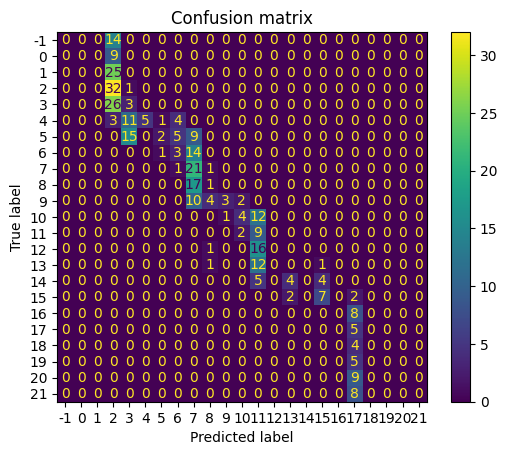

In [55]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [56]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [57]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.7s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.7s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.6s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.4s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.5s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.6s
[CV] END .max_depth=None, max_features=0.1, n_

{'n_estimators': 100, 'max_features': 0.4, 'max_depth': 100}

In [58]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.15
RMSE test: 0.49
MSE test: 0.25



(0.4949844331300691, 0.24500958904109585)

In [59]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.25
RMSE: 0.49

Round type: round
MSE: 0.28
RMSE: 0.53

Round type: 0.33
MSE: 0.27
RMSE: 0.52

Round type: 0.45
MSE: 0.25
RMSE: 0.50



### Attempt to decrease overfitting
Change max_depth to 8

In [60]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=600, max_features=0.5, max_depth=8
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.19
RMSE test: 0.51
MSE test: 0.26



(0.512942266071729, 0.26310976832280036)

In [61]:
predict = rf.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.32
RMSE: 0.56

Round type: 0.33
MSE: 0.29
RMSE: 0.54

Round type: 0.45
MSE: 0.32
RMSE: 0.56



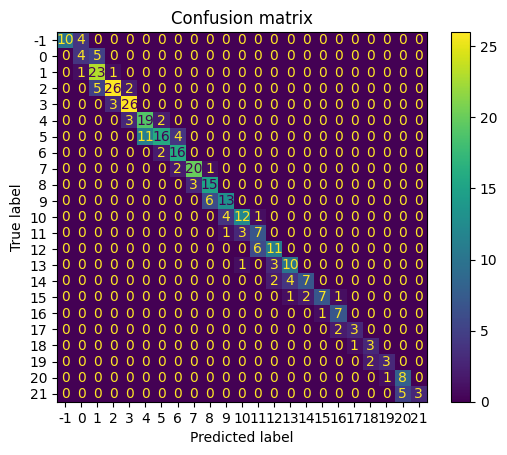

In [62]:
plot_confusion_matrix("round", predict, y_test)

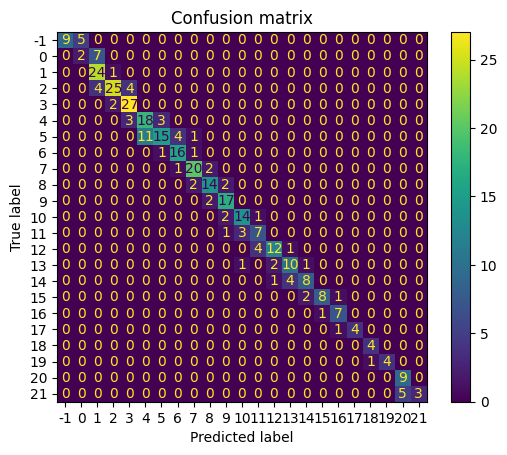

In [63]:
plot_confusion_matrix(0.33, predict, y_test)

### Random split

In [64]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [65]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [66]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.57
RMSE: 1.25


In [67]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.57
RMSE: 1.25

Round type: round
MSE: 1.66
RMSE: 1.29

Round type: 0.33
MSE: 1.68
RMSE: 1.30

Round type: 0.45
MSE: 1.65
RMSE: 1.29



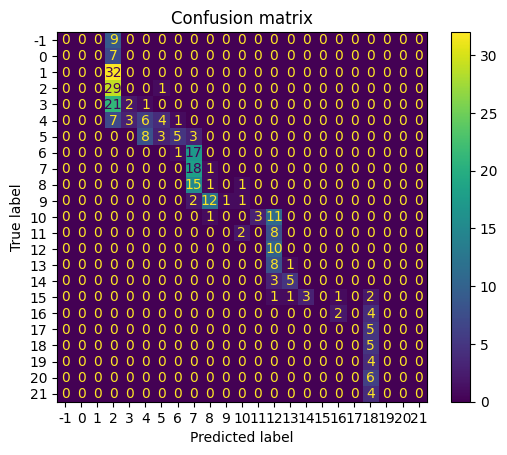

In [68]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

#### Tuning

In [69]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [ ]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.7s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.7s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.7s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.3s
[CV] END ...max_depth=70, max_features=0.5, n_

In [ ]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

### Attempt to decrease overfitting
Change max_depth to 13

In [ ]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=800, max_features=0.5, max_depth=13
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

Check rounded predictions

In [ ]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

In [ ]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

In [ ]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [ ]:
current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [ ]:
df.info()

In [ ]:
df.head()

## Train test split

### Chronological split

In [ ]:
os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

In [ ]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [ ]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [ ]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [ ]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

## With chronological split

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

In [ ]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

In [ ]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")  # overfitting

In [ ]:
check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

In [ ]:
plot_confusion_matrix("round", y_pred_test, y_test)

### Tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

In [ ]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

In [ ]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

### Attempt to decrease overfitting
Change max_depth to 8

In [ ]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=500, max_features=0.3, max_depth=8
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

In [ ]:
predict = rf.predict(X_test)

check_round_predictions(["round", 0.33, 0.45], y_test, predict)

In [ ]:
plot_confusion_matrix("round", predict, y_test)

In [ ]:
plot_confusion_matrix(0.33, predict, y_test)

## Random split

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

In [ ]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [ ]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

In [ ]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

In [ ]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

### Tuning

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

In [ ]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

In [ ]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

In [ ]:
predict_random_split = rf_random.predict(X_test_random_split)
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

### Attempt to decrease overfitting
Change max_depth to 10

In [ ]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=400, max_features=0.3, max_depth=None
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

Check rounded predictions

In [ ]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

In [ ]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

In [ ]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)